In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

from matplotlib import pyplot as plt
sys.path.insert(1, os.path.join(sys.path[0], '../../'))  # for importing local packages from src

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Palatino"],
})
plt.rcParams['text.latex.preamble'] = r'\usepackage{amsmath} \usepackage{gensymb} \usepackage{siunitx}'
plt.rcParams['font.size'] = 15
plt.rcParams['legend.fontsize'] = 12

### Loading the dataset

In [2]:
DATASET_PATH = '../datasets/dataset_NEMA3_impulse_v2.csv'

In [3]:
from rc_dataset_impulse_cnwheat import ExperimentDataset

dataset = ExperimentDataset(csv_path=DATASET_PATH)

dataset.n_runs()

11

### Figures

In [4]:
def nmse_distance(baseline, impulse):
  dist = np.empty(len(baseline))
  norm_factor = (baseline.var(axis=0) + 1e-12)
  for i_step in range(len(baseline)):
    base_state = baseline[i_step]
    state = impulse[i_step]
    dist[i_step] = ((base_state - state)**2 / norm_factor).mean()
  return dist


def get_data(run1, run2, state):
  # get raw data
  data1 = dataset.get_state(state, run1)[START:STOP]
  data2 = dataset.get_state(state, run2)[START:STOP]
  # remove NaN values
  NaN = np.isnan(data1)
  NaN_idx = np.any(NaN, axis=0)
  data1 = data1[:, ~NaN_idx]
  data2 = data2[:, ~NaN_idx]
  # calculate divergence between reservoir runs
  divergence = nmse_distance(data1, data2)
  return divergence

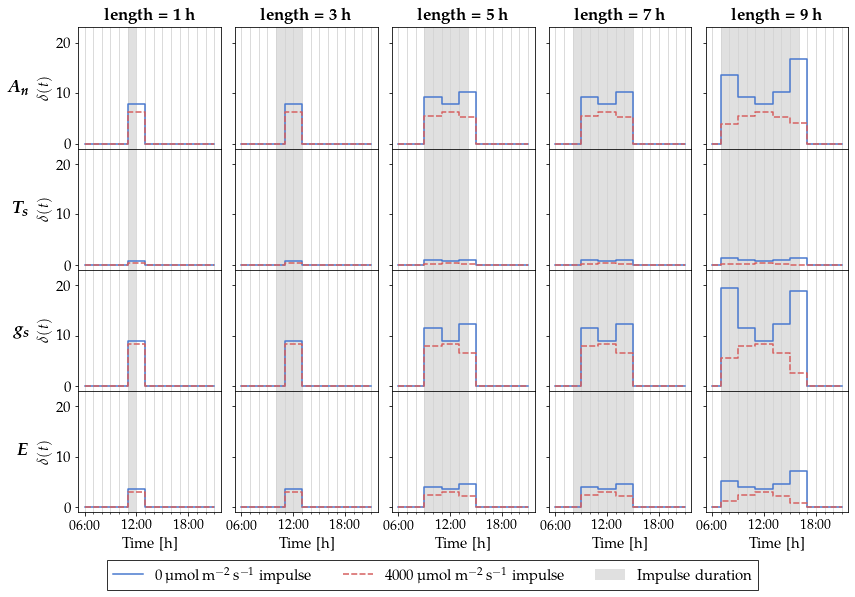

In [5]:
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)

reservoirs = [
  'state__An',
  'state__Ts',
  'state__gs',
  'state__Transpiration', 
]

symbols = {
  'state__An': r'$A_n$',
  'state__Ts': r'$T_s$',
  'state__gs': r'$g_s$',
  'state__Transpiration': r'$E$',
}

symbols_bold = {k: f'$\\boldsymbol{{{v[1:-1]}}}$' for k, v in symbols.items()}

widths = [1, 3, 5, 7, 9]

intervals = [
    (12, 13),  # width 1
    (11, 14),  # width 3
    (10, 15),  # width 5
    (9, 16),   # width 7
    (8, 17),   # width 9
]


baseline = 'NEMA_H3__day0__width0__0'
template = lambda width, value: f'NEMA_H3__day18__width{width}__{value}'

START = 18 * 24 + 6
STOP = 19 * 24 - 2


def generate_xticklabels(xticks):
  labels = []
  for x in xticks:
    # if x % 24 == 0:
    #   labels.append(f'Day {x // 24 + 1}')
    if x % 24 < 10: 
      labels.append(f'0{x % 24}:00')
    else:
      labels.append(f'{x % 24}:00')
  return labels


with plt.style.context('seaborn-muted'):
  fig, axs = plt.subplots(len(reservoirs), len(widths), figsize=(12, 8), sharex=True, sharey=True)
  colors = sns.color_palette()
  plot_colors = colors[0], colors[2]

  for row, (state, axs_row) in enumerate(zip(reservoirs, axs)):
    for col, (width, (p0, p1), ax) in enumerate(zip(widths, intervals, axs_row)):
      # get data
      pulse_lo = get_data(baseline, template(width, 0), state)
      pulse_hi = get_data(baseline, template(width, 4000), state)
      df = pd.DataFrame(pulse_lo, pulse_hi).reset_index()
      df.columns = [
        r'\SI{0}{\micro\mole\per\square\metre\per\second} impulse',
        r'\SI{4000}{\micro\mole\per\square\metre\per\second} impulse'
      ]
      df.index = np.arange(START, STOP)

      # plot data
      sns.lineplot(data=df, ax=ax, palette=plot_colors, drawstyle='steps-pre')

      # color impulse steps
      ax.axvspan(18 * 24 + p0 - 1, 18 * 24 + p1 - 1, facecolor='0.2', alpha=0.15, label='Impulse duration')

      # x axis
      xticks = np.arange(START, STOP, 1)
      ax.set_xticks(xticks)
      xticklabels = generate_xticklabels(xticks)
      xticklabels = [label if not (i) % 6 else '' for i, label in enumerate(xticklabels)]
      ax.set_xticklabels(xticklabels, fontsize=14)
      
      # gridlines and tick size
      ax.xaxis.set_major_locator(MultipleLocator(6))
      ax.xaxis.set_minor_locator(MultipleLocator(1))
      ax.grid(axis='x', linestyle='solid', color='lightgrey', which='both')
      ax.set_ylim(-1, 23)

      # labeling
      ax.set_xlabel(r'Time [\unit{\hour}]')
      ax.set_ylabel(r'$\delta(t)$')
      if col == 0:
        ax.annotate(symbols_bold[state], (-0.35, 0.5), xycoords='axes fraction', va='center', ha='right', fontsize=18)
      if row == 0:
        ax.annotate(f'\\textbf{{length = {width} h}}', (0.5, 1.07), xycoords='axes fraction', ha='center', fontsize=17)

      # cleanup
      ax.get_legend().remove()
      if ax is axs[0][0]:
        fig.legend(loc='lower center', fancybox=False, shadow=False, ncol=5, 
                    frameon=True, edgecolor='black', bbox_to_anchor=(0.5, -0.05), fontsize=15)

  plt.tight_layout()
  plt.subplots_adjust(wspace=0.1, hspace=0)  
  plt.savefig('impulse_reservoirs_cnwheat.png', dpi=200, facecolor='white', bbox_inches='tight')



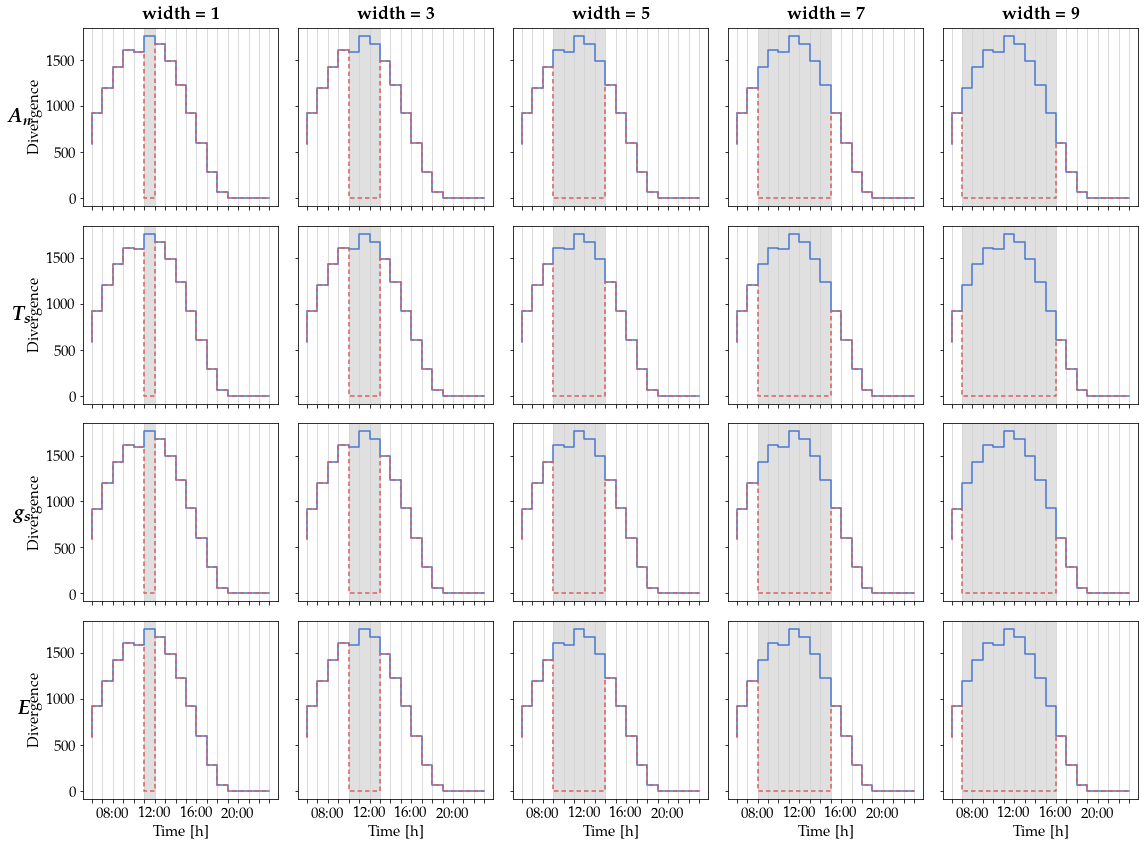

In [6]:
reservoirs = [
  'state__An',
  'state__Ts',
  'state__gs',
  'state__Transpiration', 
]

symbols = {
  'state__An': r'$A_n$',
  'state__Ts': r'$T_s$',
  'state__gs': r'$g_s$',
  'state__Transpiration': r'$E$',
}

symbols_bold = {k: f'$\\boldsymbol{{{v[1:-1]}}}$' for k, v in symbols.items()}

widths = [1, 3, 5, 7, 9]

intervals = [
    (12, 13),  # width 1
    (11, 14),  # width 3
    (10, 15),  # width 5
    (9, 16),   # width 7
    (8, 17),   # width 9
]


baseline = 'NEMA_H3__day0__width0__0'
template = lambda width, value: f'NEMA_H3__day18__width{width}__{value}'

START = 18 * 24 + 6
STOP = 19 * 24


def generate_xticklabels(xticks):
  labels = []
  for x in xticks:
    # if x % 24 == 0:
    #   labels.append(f'Day {x // 24 + 1}')
    if x % 24 < 10: 
      labels.append(f'0{x % 24}:00')
    else:
      labels.append(f'{x % 24}:00')
  return labels


with plt.style.context('seaborn-muted'):
  fig, axs = plt.subplots(len(reservoirs), len(widths), figsize=(16, 12), sharex=True, sharey=True)
  colors = sns.color_palette()

  for row, (state, axs_row) in enumerate(zip(reservoirs, axs)):
    for col, (width, (p0, p1), ax) in enumerate(zip(widths, intervals, axs_row)):
      # get data
      base = dataset.get_target('input_PARi', baseline)[START:STOP]
      experiment = dataset.get_target('input_PARi', template(width, 0))[START:STOP]

      # plot data
      base.plot(ax=ax, label="Baseline", drawstyle='steps-pre', color=colors[0])
      experiment.plot(ax=ax, dashes=(3, 2), label="Impulse", drawstyle='steps-pre', color=colors[2])  

      # color impulse steps
      ax.axvspan(18 * 24 + p0 - 1, 18 * 24 + p1 - 1, facecolor='0.2', alpha=0.15)

      # x axis
      xticks = np.arange(START, STOP, 1)
      ax.set_xticks(xticks)
      xticklabels = generate_xticklabels(xticks)
      xticklabels = [label if not (i + 2) % 4 else '' for i, label in enumerate(xticklabels)]
      ax.set_xticklabels(xticklabels)
      ax.grid(axis='x', linestyle='solid', color='lightgrey')

      # labeling
      ax.set_xlabel(r'Time [\unit{\hour}]')
      ax.set_ylabel(r'Divergence')

      if col == 0:
        ax.annotate(symbols_bold[state], (-0.27, 0.5), xycoords='axes fraction', va='center', ha='right', fontsize=20)

      if row == 0:
        ax.annotate(f'\\textbf{{width = {width}}}', (0.5, 1.05), xycoords='axes fraction', ha='center', fontsize=18)


  plt.tight_layout()
  plt.savefig('impulse_inputs_cnwheat.png', dpi=200, facecolor='white')



In [7]:
import inspect
lines = inspect.getsource(get_data)
print(lines)

def get_data(run1, run2, state):
  # get raw data
  data1 = dataset.get_state(state, run1)[START:STOP]
  data2 = dataset.get_state(state, run2)[START:STOP]
  # remove NaN values
  NaN = np.isnan(data1)
  NaN_idx = np.any(NaN, axis=0)
  data1 = data1[:, ~NaN_idx]
  data2 = data2[:, ~NaN_idx]
  # calculate divergence between reservoir runs
  divergence = nmse_distance(data1, data2)
  return divergence

